Now that we have collected a lot of data, let's try to combine it all and see if it's useful in prediction! Let's assume that the task is nowcasting, that we are given data up to this year and have to predict the refugee traffic of the current year.

First, let's load in the data sources

In [3]:
import pandas as pd
import numpy as np

path = '../../data/clean/'

# data from geraldine
unhcr = pd.read_csv(path + 'unhcr.csv', engine='pyarrow')

# yearly sources from the internet
idp = pd.read_csv(path + 'idp.csv', engine='pyarrow')
fsi = pd.read_csv(path + 'fragility_indices.csv', engine='pyarrow')
migration = pd.read_csv(path + 'migration_stocks.csv')

# monthly sources from hannes + gdelt team
conflict = pd.read_csv(path + 'mueller_conflict_forecasts.csv')
lda = pd.read_csv(path + 'lda.csv')
gdelt = pd.read_csv(path + 'gdelt.csv', engine='pyarrow')

trends_path = '../../data/clean/trends/'

# monthly trends data
semantic_trends = pd.read_csv(trends_path + 'semantic_trends.csv').rename({'country':'country_o'}, axis=1)
city_trends_corridor = pd.read_csv(trends_path + 'city_trends_corridor.csv').drop('Unnamed: 0', axis=1)
country_trends_corridor = pd.read_csv(trends_path + 'country_trends_corridor.csv').rename({'topic_title':'country_d'}, axis=1)
# border_cities_trends = pd.read_csv(trends_path + 'bordering_cities_trends.csv')

That's a lot of sources!

First, let's create columns for the continent.

In [ ]:
an_index = unhcr[['iso_o','iso_d','year','Id']].copy()
columns_to_drop = ['Country_o','Country_d']
unhcr.drop(columns_to_drop, axis=1, inplace=True)

This is a mapper to get the continent for a given country.

In [ ]:
import pycountry_convert as pc

def country_to_continent(iso3):
    if iso3 == 'UVK':
        return 'EU'
    elif iso3 =='TLS':
        return 'OC'
    elif iso3 =='WBG':
        return 'AS'

    country_alpha2 = pc.country_alpha3_to_country_alpha2(iso3)
    country_continent_code = pc.country_alpha2_to_continent_code(country_alpha2)
    return country_continent_code

In [ ]:
continents = unhcr[['iso_o','iso_d']].apply(lambda x: mapper(x, country_to_continent, suffix='_continent')).rename({'iso_o':'iso_o_continent','iso_d':'iso_d_continent'}, axis=1)
unhcr = pd.concat([continents, unhcr], axis=1)

In [110]:
unhcr_extra = unhcr.merge(idp.drop('', axis=1), on=['iso_o', 'year'], how='left') \
    .merge(fsi, left_on=['iso_o', 'year'], right_on=['iso', 'year'], how='left') \
    .drop('iso', axis=1) \
    .merge(fsi, left_on=['iso_d', 'year'], right_on=['iso', 'year'], how='left', suffixes=('_o','_d')) \
    .drop('iso', axis=1) \
    .merge(migration, on=['year','iso_o','iso_d'])

In [111]:
import gc
def trash_collector(obj_list):
    for obj in obj_list:
        del obj
    return gc.collect()

del fsi; del idp; del migration; del continents; gc.collect()

0

We need to convert conflict, lda, and gdelt to a yearly format.

There are multiple ways to do this. A simple approach is to summarize and do boxplots of the months, aggregating to yearly data. 

Here we have the function agg_year, which produces a boxplot, but also includes the log difference of the data, to represent the average log change for a given year.

In [5]:
def avg_log_diff(series):
    val = np.log1p(series).diff().mean()
    if np.isnan(val):
        return 0
    else:
        return val

# Define the agg_year function
def agg_year(series):
    # Calculate the statistics using numpy
    minimum = np.min(series)
    q25 = np.percentile(series, 25)
    median = np.median(series)
    q75 = np.percentile(series, 75)
    maximum = np.max(series)
    log_diff = avg_log_diff(series)
    
    # Return the statistics as a list
    return [minimum, q25, median, q75, maximum, log_diff]

def split_nested_list(series):
    df = pd.DataFrame(series.apply(pd.Series).values.tolist())
    df.columns = series.name + '_' + pd.Series(['min','25th','median','75th','max', 'log_diff'])
    return df

def split_df(df):
    new_df = pd.concat([split_nested_list(df[col]) for col in df.columns], axis=1)
    new_df.index = df.index
    return new_df

In [7]:
# apply this to conflict data
conflict = conflict.groupby(['isocode', 'year'])[['ons_armedconf12_pred_top_x', 'ons_armedconf12_pred_top_y', 'lnbest_pc_12_pred_top']].agg(agg_year)

conflict = split_df(conflict)

In [9]:
# now the lda data
lda = lda.groupby(['isocode','year'])[['ste_theta0', 'ste_theta1', 'ste_theta2', 'ste_theta3',
       'ste_theta4', 'ste_theta5', 'ste_theta6', 'ste_theta7', 'ste_theta8',
       'ste_theta9', 'ste_theta10', 'ste_theta11', 'ste_theta12',
       'ste_theta13', 'ste_theta14']].agg(agg_year)
lda = split_df(lda)

In [10]:
gdelt = gdelt.groupby(['isocode','year'])[['count_events_1',
       'count_events_2', 'count_events_3', 'count_events_4', 'count_events_5',
       'count_events_6', 'count_events_7', 'count_events_8', 'count_events_9',
       'count_events_10', 'count_events_11', 'count_events_12',
       'count_events_13', 'count_events_14', 'count_events_15',
       'count_events_16', 'count_events_17', 'count_events_18',
       'count_events_19', 'count_events_20']].agg(agg_year)
gdelt = split_df(gdelt)

Let's merge with the monthly sources that have been aggregated

In [ ]:
unhcr_extra = unhcr_extra.merge(conflict, how='left',left_on=['iso_o','year'], right_on=['isocode','year']) \
    .merge(lda, how='left', left_on=['iso_o','year'], right_on=['isocode','year']) \
    .merge(gdelt,  how='left', left_on=['iso_o','year'], right_on=['isocode','year'])

trash_collector([conflict, lda, gdelt])

Trends data

In [126]:
def mapper(series, converter, suffix=''):
    unique_keys = series.drop_duplicates()
    unique_vals = unique_keys.apply(converter)
    mapper_dict = dict(zip(unique_keys, unique_vals))
    series = series.map(mapper_dict)
    series.name = series.name + suffix
    return series

import country_converter as coco
def country_to_iso2(long):
    return coco.convert(long, to='iso2')

def country_to_iso3(long):
    return coco.convert(long, to='iso3')

In [90]:
semantic_trends['year'] = semantic_trends.date.str[:4].astype(int)
city_trends_corridor['year'] = city_trends_corridor.date.str[:4].astype(int)
country_trends_corridor['year'] = country_trends_corridor.date.str[:4].astype(int)

semantic_trends = semantic_trends.loc[semantic_trends.year < 2023,:]
country_trends_corridor = country_trends_corridor.loc[country_trends_corridor.year < 2023,:]

city_trends_corridor['country_d'] = mapper(city_trends_corridor.country_d, country_to_iso2)
country_trends_corridor['country_d'] = mapper(country_trends_corridor.country_d, country_to_iso2)

In [92]:
trends = city_trends_corridor.merge(country_trends_corridor.rename({'topic_title':'country_d','value':'country_value'}, axis=1), on=['date','country_o','country_d','year'], how='outer').merge(semantic_trends, on=['date','year','country_o'], how='left')
trends.fillna(0, inplace=True)

In [96]:
def agg_trends(series):
    q25 = np.percentile(series, 25)
    median = np.median(series)
    q75 = np.percentile(series, 75)
    return [q25, median, q75]

def split_nested_trends(series):
    df = pd.DataFrame(series.apply(pd.Series).values.tolist())
    df.columns = series.name + '_' + pd.Series(['25th','median','75th'])
    return df

def split_trends(df):
    new_df = pd.concat([split_nested_trends(df[col]) for col in df.columns], axis=1)
    new_df.index = df.index
    return new_df

In [114]:
trends = trends.groupby(['year','country_o','country_d'])[['cities_value_min',
       'cities_value_25th', 'cities_value_median', 'cities_value_75th',
       'cities_value_max', 'country_value', 'value_min_Civil/Social',
       'value_min_Economic', 'value_min_Travel',
       'value_min_conflict, violence', 'value_25th_Civil/Social',
       'value_25th_Economic', 'value_25th_Travel',
       'value_25th_conflict, violence', 'value_median_Civil/Social',
       'value_median_Economic', 'value_median_Travel',
       'value_median_conflict, violence', 'value_75th_Civil/Social',
       'value_75th_Economic', 'value_75th_Travel',
       'value_75th_conflict, violence', 'value_max_Civil/Social',
       'value_max_Economic', 'value_max_Travel',
       'value_max_conflict, violence']].agg(agg_trends)

trends = split_trends(trends).reset_index()

In [127]:
trends['country_o'] = mapper(trends.country_o, country_to_iso3)
trends['country_d'] = mapper(trends.country_d, country_to_iso3)

0 not found in ISOnumeric


In [130]:
# there is a zero value here i need to investigate later
unhcr_extra = unhcr_extra.merge(trends.rename({'country_o':'iso_o', 'country_d':'iso_d'}, axis=1), how='left',on=['iso_o','iso_d','year'])

del city_trends_corridor; del country_trends_corridor; del  semantic_trends; del  trends; del continents; gc.collect()

And now, let's create a lagged features, in this case let's do 2 years of lagged features.

In [144]:
from multiprocesspandas import applyparallel

def multi_shift(df, shift_range, columns):
    shifted_data = [df[columns].shift(shift_value) for shift_value in range(shift_range.start, shift_range.stop)]
    shifted_df = pd.concat(shifted_data, axis=1, keys=[f'Shift_{shift_value}' for shift_value in range(shift_range.start, shift_range.stop)])
    shifted_df.columns = shifted_df.columns.map(lambda col: '_'.join(col).strip())
    return shifted_df

shift_cols = ['newarrival','dead_o','fsi_overall_o','dead_d','ons_armedconf12_pred_top_x_mean', 'ons_armedconf12_pred_top_x_75th', 'ons_armedconf12_pred_top_x_log_diff']

shifted_features = unhcr_extra[shift_cols].copy()
shifted_features = pd.concat([shifted_features, an_index], axis=1).set_index(an_index.columns.tolist()).groupby('Id', group_keys=False).apply(lambda x: multi_shift(x, range(1,3), shift_cols))

In [147]:
unhcr_extra = pd.concat([unhcr_extra, shifted_features.reset_index(drop=True)], axis=1)

In [148]:
del shifted_features; del an_index; gc.collect()

0

In [175]:
trends_cols = ['cities_value_min_25th',
 'cities_value_min_median',
 'cities_value_min_75th',
 'cities_value_25th_25th',
 'cities_value_25th_median',
 'cities_value_25th_75th',
 'cities_value_median_25th',
 'cities_value_median_median',
 'cities_value_median_75th',
 'cities_value_75th_25th',
 'cities_value_75th_median',
 'cities_value_75th_75th',
 'cities_value_max_25th',
 'cities_value_max_median',
 'cities_value_max_75th',
 'country_value_25th',
 'country_value_median',
 'country_value_75th',
 'value_min_Civil/Social_25th',
 'value_min_Civil/Social_median',
 'value_min_Civil/Social_75th',
 'value_min_Economic_25th',
 'value_min_Economic_median',
 'value_min_Economic_75th',
 'value_min_Travel_25th',
 'value_min_Travel_median',
 'value_min_Travel_75th',
 'value_min_conflict, violence_25th',
 'value_min_conflict, violence_median',
 'value_min_conflict, violence_75th',
 'value_25th_Civil/Social_25th',
 'value_25th_Civil/Social_median',
 'value_25th_Civil/Social_75th',
 'value_25th_Economic_25th',
 'value_25th_Economic_median',
 'value_25th_Economic_75th',
 'value_25th_Travel_25th',
 'value_25th_Travel_median',
 'value_25th_Travel_75th',
 'value_25th_conflict, violence_25th',
 'value_25th_conflict, violence_median',
 'value_25th_conflict, violence_75th',
 'value_median_Civil/Social_25th',
 'value_median_Civil/Social_median',
 'value_median_Civil/Social_75th',
 'value_median_Economic_25th',
 'value_median_Economic_median',
 'value_median_Economic_75th',
 'value_median_Travel_25th',
 'value_median_Travel_median',
 'value_median_Travel_75th',
 'value_median_conflict, violence_25th',
 'value_median_conflict, violence_median',
 'value_median_conflict, violence_75th',
 'value_75th_Civil/Social_25th',
 'value_75th_Civil/Social_median',
 'value_75th_Civil/Social_75th',
 'value_75th_Economic_25th',
 'value_75th_Economic_median',
 'value_75th_Economic_75th',
 'value_75th_Travel_25th',
 'value_75th_Travel_median',
 'value_75th_Travel_75th',
 'value_75th_conflict, violence_25th',
 'value_75th_conflict, violence_median',
 'value_75th_conflict, violence_75th',
 'value_max_Civil/Social_25th',
 'value_max_Civil/Social_median',
 'value_max_Civil/Social_75th',
 'value_max_Economic_25th',
 'value_max_Economic_median',
 'value_max_Economic_75th',
 'value_max_Travel_25th',
 'value_max_Travel_median',
 'value_max_Travel_75th',
 'value_max_conflict, violence_25th',
 'value_max_conflict, violence_median',
 'value_max_conflict, violence_75th']

unhcr_extra[trends_cols]  = unhcr_extra[trends_cols].fillna(0)

In [177]:
from category_encoders import BinaryEncoder

be = BinaryEncoder()

def create_train_test(unhcr_extra, split, encoder):
    unhcr_extra = unhcr_extra.copy()

    newarrival_not_na = (~unhcr_extra.newarrival.isna()) & (~unhcr_extra.Shift_2_newarrival.isna())
    train_idx = (unhcr_extra.year > 2007) & (unhcr_extra.year <= split) & newarrival_not_na
    test_idx = (unhcr_extra.year > split) & newarrival_not_na

    y_pred_naive = unhcr_extra.groupby('Id').newarrival.shift(1).loc[test_idx]
    
    unhcr_extra = encoder.fit_transform(unhcr_extra)
    
    X_train = unhcr_extra.loc[train_idx, unhcr_extra.columns != 'newarrival']
    y_train = unhcr_extra.loc[train_idx , 'newarrival']
    X_test = unhcr_extra.loc[test_idx, unhcr_extra.columns != 'newarrival']
    y_test = unhcr_extra.loc[test_idx, 'newarrival']
    
    return X_train, y_train, X_test, y_test, y_pred_naive

X_train, y_train, X_test, y_test, y_naive = create_train_test(unhcr_extra, 2017, be)

In [178]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestRegressor(n_jobs=-1)

In [183]:
y_pred = rf.predict(X_test)

Shift_1_newarrival                   0.490737
fsi_external_intervention_d          0.031221
ste_theta2_stock_log_diff            0.028583
value_max_conflict, violence_25th    0.017085
ste_theta8_mean                      0.014847
Shift_2_newarrival                   0.012959
count_events_20_log_diff             0.010673
cities_value_max_25th                0.008582
fsi_state_legitimacy_d               0.008554
ste_theta8_25th                      0.008465
dtype: float64

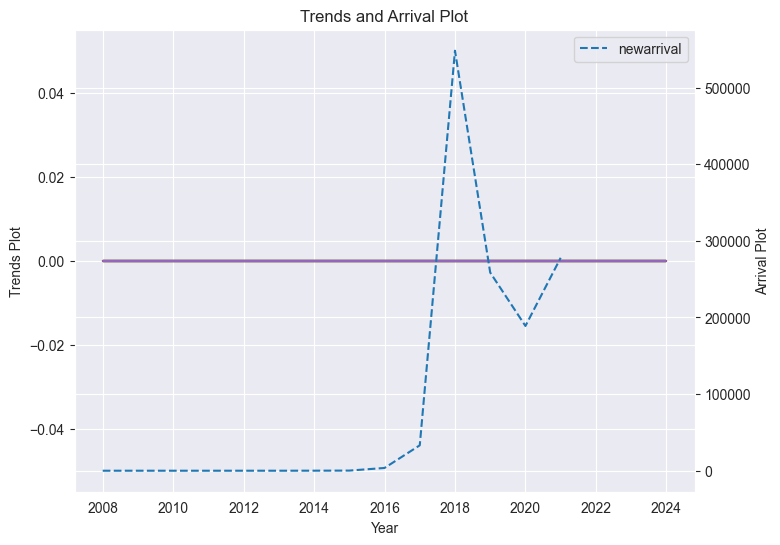

In [256]:
import matplotlib.pyplot as plt

country_Id = 'VENPER'

fig, ax1 = plt.subplots(figsize=(8, 6))

yr_filter = 2008

# Plotting the first plot
trends_plot = unhcr_extra.loc[(unhcr_extra.Id == country_Id) & (unhcr_extra.year >= yr_filter), unhcr_extra.columns.str.contains('citi') | (unhcr_extra.columns == 'year')].set_index('year').plot(ax=ax1, legend=False)

# Creating the second plot with a second y-axis
ax2 = ax1.twinx()

# Plotting the second plot as a dotted line
arrival_plot = unhcr_extra.loc[(unhcr_extra.Id == country_Id) & (unhcr_extra.year >= yr_filter), ['newarrival','year']].set_index('year').plot(ax=ax2, style='--')

# Labeling the axes
ax1.set_xlabel('Year')
ax1.set_ylabel('Trends Plot')
ax2.set_ylabel('Arrival Plot')

# Adding a legend for both plots
# lines_1, labels_1 = ax1.get_legend_handles_labels()
# lines_2, labels_2 = ax2.get_legend_handles_labels()
# ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')

plt.title('Trends and Arrival Plot')
plt.show()


In [245]:
unhcr_extra.columns.tolist()


['iso_o_continent',
 'iso_d_continent',
 'iso_o',
 'iso_d',
 'year',
 'pop_o',
 'CPI_o',
 'GDP_PP_o',
 'GDP_PPP_o',
 'island_o',
 'area_o',
 'landlocked_o',
 'PR_o',
 'CL_o',
 'typeOfViolence_o',
 'best_est_o',
 'Nyear_conflict_o',
 'Nyear_log_o',
 'dead_log_o',
 'Nyear_conf_o',
 'dead_o',
 'pop_d',
 'CPI_d',
 'GDP_PP_d',
 'GDP_PPP_d',
 'island_d',
 'area_d',
 'landlocked_d',
 'PR_d',
 'CL_d',
 'typeOfViolence_d',
 'best_est_d',
 'Nyear_conflict_d',
 'Nyear_log_d',
 'dead_log_d',
 'Nyear_conf_d',
 'dead_d',
 'newarrival',
 'index0asylum',
 'Id',
 'contig',
 'comlang_off',
 'comlang_ethno',
 'colony',
 'comcol',
 'col45',
 'smctry',
 'dist',
 'ons_armedconf12_pred_top_x_min',
 'ons_armedconf12_pred_top_x_25th',
 'ons_armedconf12_pred_top_x_mean',
 'ons_armedconf12_pred_top_x_75th',
 'ons_armedconf12_pred_top_x_max',
 'ons_armedconf12_pred_top_x_log_diff',
 'ons_armedconf12_pred_top_y_min',
 'ons_armedconf12_pred_top_y_25th',
 'ons_armedconf12_pred_top_y_mean',
 'ons_armedconf12_pred_top

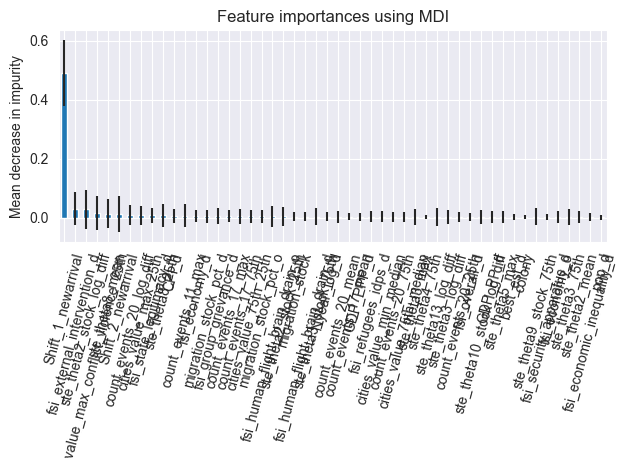

In [244]:
import matplotlib.pyplot as plt
forest_importances = pd.Series(rf.feature_importances_, index=rf.feature_names_in_)

std = pd.Series(np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0), index=rf.feature_names_in_)

importances = forest_importances.nlargest(50)
idx = importances.index
fig, ax = plt.subplots()

importances.plot.bar(yerr=std[idx], ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
plt.xticks(rotation = 75)
fig.tight_layout()

In [184]:
from sklearn.metrics import mean_squared_error

mean_squared_error(y_test, y_pred, squared=False)/mean_squared_error(y_test, y_naive, squared=False)

0.8648841393169808

In [186]:
results_df= pd.concat([y_test.reset_index(drop=True),y_naive.rename('naive').reset_index(drop=True),pd.Series(y_pred, name='RF_model')], axis=1)

In [187]:
# Compute RMSE for each row
results_df['naive_error'] = np.sqrt((results_df['newarrival'] - results_df['naive']) ** 2)
results_df['RF_error'] = np.sqrt((results_df['newarrival'] - results_df['RF_model']) ** 2)
# results_df['RF_outflow_error'] = np.sqrt((results_df['newarrival'] - results_df['RF_outflow']) ** 2)

# Define the ranges for grouping the actual values
ranges = [0, 10, 100, 1000,10000,100000, 1200000]  # Modify the ranges as per your requirements
labels = ['0-10', '10-100', '100-1k', '1k-10k','10k-100k','100k+']  # Labels for the groups
# Group the errors based on ranges of actual values
results_df['actual_range'] = pd.cut(results_df['newarrival'], ranges, labels=labels, include_lowest=True)

In [188]:
# Compute mean RMSE for each group
grouped_errors = results_df[['naive_error', 'RF_error','actual_range']].groupby('actual_range').mean()
grouped_errors

,naive_error,RF_error
actual_range,,
0-10,2.033208,6.926709
10-100,36.209227,101.802675
100-1k,280.194662,919.089117
1k-10k,2386.465937,4888.936253
10k-100k,31011.180556,33913.990278
100k+,240486.625000,201650.860000


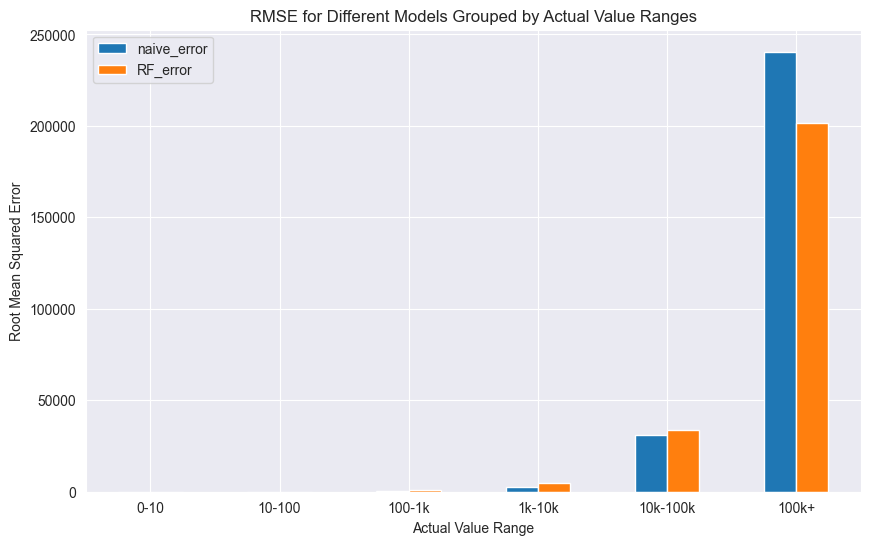

In [189]:
# Plot the bar plot
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('darkgrid')
grouped_errors.plot(kind='bar', figsize=(10, 6))
plt.xlabel('Actual Value Range')
plt.ylabel('Root Mean Squared Error')
plt.title('RMSE for Different Models Grouped by Actual Value Ranges')
plt.xticks(rotation=0)
# plt.yscale('log')
plt.legend()
plt.show()

In [190]:
results_df['newarrival - RF'] = results_df['newarrival'] - results_df['RF_model']
results_df['newarrival - naive'] = results_df['newarrival'] - results_df['naive']
results_df.loc[results_df['RF_model'] <= 1, 'RF_model'] = np.round(results_df.loc[results_df['RF_model'] <= 1, 'RF_model'])

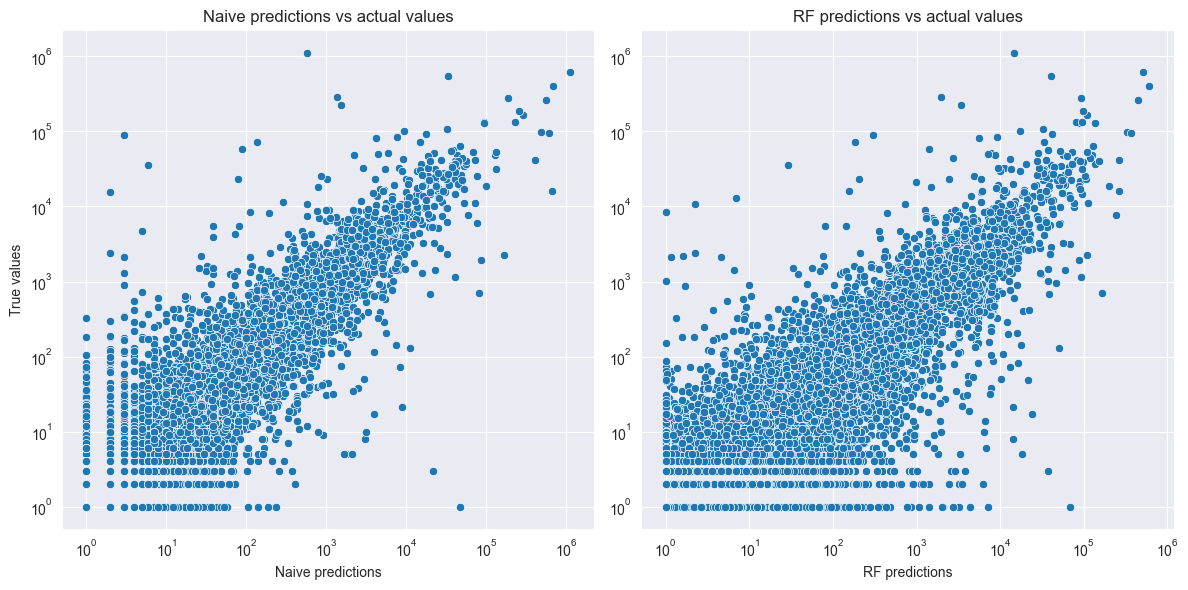

In [191]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot the first subplot
sns.scatterplot(data=results_df, x='naive', y='newarrival', ax=axes[0])
axes[0].set_xlabel('Naive predictions')
axes[0].set_ylabel('True values')
axes[0].set_title('Naive predictions vs actual values')
axes[0].set_xscale('log')
axes[0].set_yscale('log')

# Plot the second subplot (modify the column names accordingly)
sns.scatterplot(data=results_df, x='RF_model', y='newarrival', ax=axes[1])
axes[1].set_xlabel('RF predictions')
axes[1].set_ylabel('')
axes[1].set_xscale('log')
axes[1].set_yscale('log')
axes[1].set_title('RF predictions vs actual values')

# Adjust the layout and display the plot
plt.tight_layout()
plt.show()
